# Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [4]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('temperatures', 'SMHI_dewp'),
    ('temperatures', 'SMHI'),
    ('wind', 'SMHI_direction'),
    ('wind', 'SMHI_speed'),
    ('setpoints', 'TA01_GT10X_GM10X_default')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

# check for NaNs
nadat = data.droplevel(level=0, axis=1)[[
    'TA01_GP101_default', 
    #'FF01_GP101_default',
    #'DC_GP101_default',
    'TA01_GT10X_GM10X_default'
]]

# delete Nan-data
del nadat

Number of NAs

category      sensor_ID               
flow          TA01_GP101_default          0
temperatures  DC_GT401_GM401              0
              TA01_GT401_GM401            0
              TA02_GT401_GM401            0
              TA01_GT10X_GM10X            0
              DC_GT301_damped             0
              DC_GT301_outdoor            0
              SMHI_dewp                   0
              SMHI                        0
wind          SMHI_direction              0
              SMHI_speed                  0
setpoints     TA01_GT10X_GM10X_default    0
dtype: int64





## Process / transform variables 

In [6]:
# remove erroneous setpoints data
#data[data.setpoints.TA01_GT10X_GM10X_default == 0.0].TA01_GT10X_GM10X_default = 20.0
data = data[data.setpoints.TA01_GT10X_GM10X_default != 0.0]

# Use temperature Diff. w.r.t. setpoint
data[('temperatures', 'TA01_GT10X_GM10X_diff')] = \
    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

In [7]:
# create variable f. time to account for time-specific effects (e.g. transpiration)

data[('time', 'minutes')] = data.index.get_level_values(3)
data[('time', 'min_sin')] = data.time.minutes.apply(
    lambda d: abs(np.sin((d.hour * 60 + d.minute) * (2 * np.pi / (24 * 60 * 60))))
)
data[('time', 'min_cos')] = data.time.minutes.apply(
    lambda d: abs(np.cos((d.hour * 60 + d.minute) * (2 * np.pi / (24 * 60 * 60))))
)

In [8]:
# create variable f. wind distribution
wv = data.pop(('wind', 'SMHI_speed'))

# Convert to radians.
wd_rad = data.pop(('wind', 'SMHI_direction'))*np.pi / 180

# Calculate the wind x and y components.
data[('wind', 'Wx')] = wv*np.cos(wd_rad)
data[('wind', 'Wy')] = wv*np.sin(wd_rad)

### Plot pairwise correlation matrix

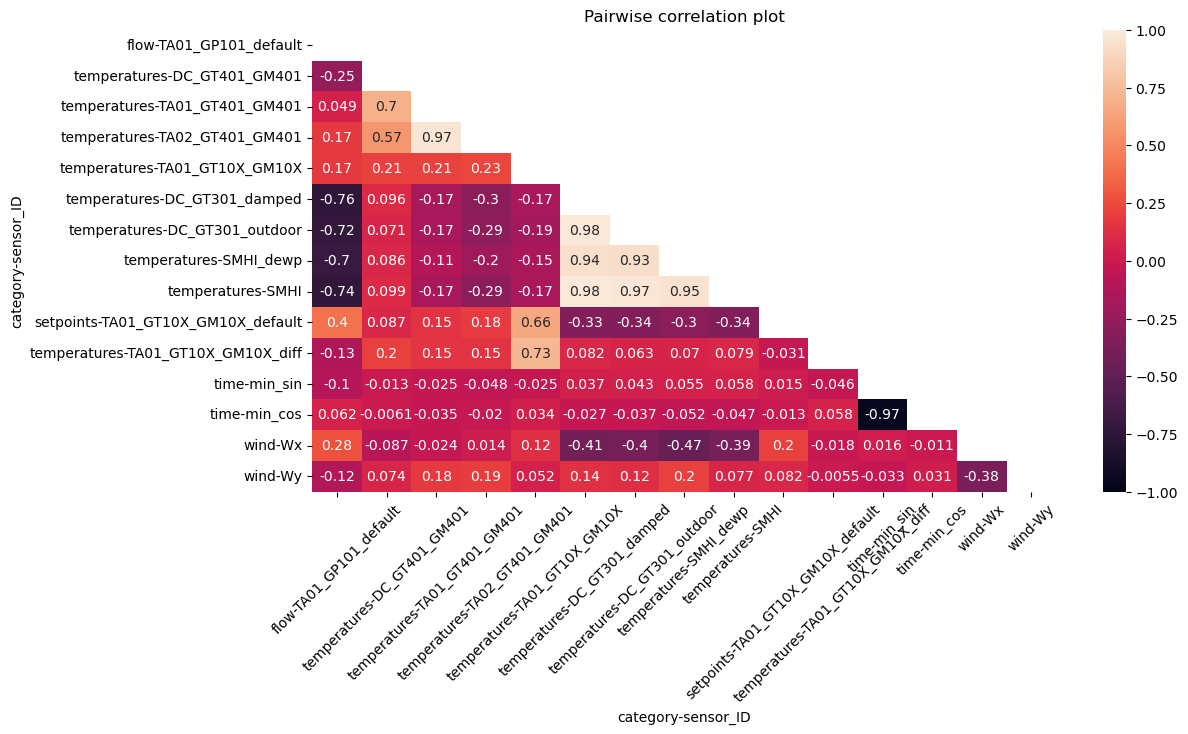

In [9]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

plt.xticks(rotation=45)
plt.title('Pairwise correlation plot')
plt.show()

# delete correlation data
del corr

## Preparing data

In [ ]:
# drop index levels
subset = subset.droplevel(level = [0, 1, 2], axis=0)

# shuffle dataset
subset = subset.sample(frac = 1.0)

# create tfds instance
tf_subset = tf.data.Dataset.from_tensor_slices(subset)

# split tfds
train_n = int(len(subset) * 0.8)
test_n = len(subset) - train_n

# get datasets
tfds_train = tf_subset.take(train_n)
tfds_test = tf_subset.take(test_n)

# del subset and data
del subset, tf_subset, data

In [10]:
# Define model variables
model_vars = [
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    #('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'TA01_GT10X_GM10X_diff'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('temperatures', 'SMHI_dewp'),
    ('temperatures', 'SMHI'),
    ('wind', 'Wx'),
    ('wind', 'Wy'),
    ('time', 'min_sin'),
    ('time', 'min_cos')
]

In [11]:
# Define target variable
target = ('temperatures', 'TA01_GT10X_GM10X_diff')
#target = ('temperatures', 'TA01_GT10X_GM10X')

# Define boolean mask f. train/test split
mask = data.index.get_level_values(0) == 2

# split data
data_train = data[~mask][model_vars].copy()
data_test  = data[mask][model_vars].copy()

# delete o.g. data & filtering mask
del data, mask

# get y_vals
Y_train = data_train.pop(target).values
Y_test = data_test.pop(target).values

# get x_vals
X_train = data_train.values
X_test = data_test.values


In [12]:
# Whiten data, define func

def data_whitening(data_train, data_test):
    
    mean = np.mean(
        data_train, 
        axis=0
    )

    std = np.std(
        data_train, 
        axis=0
    )
    
    data_train = (data_train - mean) / std
    data_test = (data_test - mean) / std
    
    return data_train, data_test
    

In [13]:
# Whiten data, X, Y

X_train, X_test = data_whitening(X_train, X_test)
Y_train, Y_test = data_whitening(Y_train, Y_test)

## Define model

In [14]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
        #X_train.shape[2]
    )),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation=None)
]

In [15]:
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1664      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 100,737
Trainable params: 100,737
Non-trainable

In [16]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/10
790/790 [==============================] - 10s 10ms/step - loss: 0.4524 - val_loss: 0.4672
Epoch 2/10
790/790 [==============================] - 7s 9ms/step - loss: 0.3324 - val_loss: 0.4475
Epoch 3/10
790/790 [==============================] - 7s 9ms/step - loss: 0.2776 - val_loss: 0.4938
Epoch 4/10
790/790 [==============================] - 7s 9ms/step - loss: 0.2476 - val_loss: 0.4623
Epoch 5/10
790/790 [==============================] - 7s 9ms/step - loss: 0.2298 - val_loss: 0.6009
Epoch 6/10
790/790 [==============================] - 7s 9ms/step - loss: 0.2105 - val_loss: 0.6317
Epoch 7/10
790/790 [==============================] - 7s 9ms/step - loss: 0.2064 - val_loss: 0.5128
